In [209]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint, seed
from rasterio.plot import show
from rasterio.windows import Window
from itertools import compress
plt.switch_backend('TKagg')
%matplotlib inline

In [210]:
src = rasterio.open('../depth_dDEMs/hv/corrected/hv_depth_107_2012_corrected_-0.04_m.tif')
width = src.meta['width']
height = src.meta['height']

if width >= height:
    ratio = round(width / height, 2)
else:
    ratio = round(height / width, 2)

print('ratio ', ratio)
fudge = (1 / (ratio))
print('fudge ', fudge)

hlimit = int((height)*fudge)

wlimit = int((width) * (1- fudge))

print(wlimit, hlimit)
print(src.meta)
northing = src.meta['transform'][5] # northing
easting = src.meta['transform'][2] # easting
print(easting, northing)

x_pad = 0.10 * width
y_pad = 0.10 * height
print(x_pad, y_pad)

ratio  4.53
fudge  0.22075055187637968
2649 3399
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3400, 'height': 15400, 'count': 1, 'crs': CRS({'init': 'epsg:32606'}), 'transform': Affine(1.0, 0.0, 421000.0,
       0.0, -1.0, 7678000.0)}
421000.0 7678000.0
340.0 1540.0


In [214]:
# Get random (size and location) 

#seed(2)
win_x_starts = [randint(x_pad, width - x_pad) for p in range(0, 5000)]

#seed(3)
win_y_starts = [randint(y_pad, height - y_pad) for p in range(0, 5000)]

#seed(0)
win_widths = [randint(100, wlimit) for p in range(0, 5000)]

#seed(1)
win_heights = [randint(100, hlimit) for p in range(0, 5000)]

#print(win_x_starts[0], win_y_starts[0])
#print(win_widths[0], win_heights[0])
win_x_stops =[sum(x) for x in zip(win_x_starts, win_widths)]
win_y_stops = [sum(y) for y in zip(win_y_starts, win_heights)]
#print(win_x_stops[0], win_y_stops[0])

aoi_windows = list(zip(zip(win_y_starts, win_y_stops), zip(win_x_starts, win_x_stops)))

print(len(aoi_windows), ' random AOI windows were generated...')

culled_aois = [s for s in aoi_windows if s[0][1] <= height and s[1][1] <= width]

print(len(culled_aois), ' AOI windows are valid. Filtered to remove windows that are out of bounds.')

culled_aois = [s for s in culled_aois if ((s[0][1] - s[0][0]) / (s[1][1] - s[1][0])) <= 2]

print(len(culled_aois), ' AOI windows are valid. Filtered to remove tall and skinny windows.')

culled_aois = [s for s in culled_aois if ((s[1][1] - s[1][0]) / (s[0][1] - s[0][0])) <= 2]

print(len(culled_aois), ' AOI windows are valid. Filtered to remove short and fat windows.')

# print('((row_start, row_stop), (col_start, col_stop))')
# for a in culled_aois:
#     print(a)


5000  random AOI windows were generated...
2985  AOI windows are valid. Filtered to remove windows that are out of bounds.
1715  AOI windows are valid. Filtered to remove tall and skinny windows.
1266  AOI windows are valid. Filtered to remove short and fat windows.


In [215]:
tl_start_coords = [(i[0][0], i[1][0]) for i in culled_aois]
tl_start_coords = [i[::-1] for i in tl_start_coords]
tl_utm_coords = [(i[0] + easting , northing - i[1]) for i in tl_start_coords]

# print("Top Left Coords:")
# for c in tl_start_coords:
#     print(c)
# for c in tl_utm_coords:
#     print(c)

br_coords = [(i[0][1], i[1][1]) for i in culled_aois]
br_coords = [i[::-1] for i in br_coords]
br_utm_coords = [(i[0] + easting , northing - i[1]) for i in br_coords]

# print("Bottom Right Coords:")
# for c in br_coords:
#     print(c)
# for c in br_utm_coords:
#     print(c)

tr_coords = [(i[0][0], i[1][1]) for i in culled_aois]

tr_coords = [i[::-1] for i in tr_coords]
tr_utm_coords = [(i[0] + easting , northing - i[1]) for i in tr_coords]

# print("Top Right Coords:")
# for c in tr_coords:
#     print(c)
# for c in tr_utm_coords:
#     print(c)
    
bl_coords = [(i[0][1], i[1][0]) for i in culled_aois]
bl_coords = [i[::-1] for i in bl_coords]
bl_utm_coords = [(i[0] + easting , northing - i[1]) for i in bl_coords]

#print("Bottom Left Coords:")
# for c in bl_coords:
#     print(c)
# for c in bl_utm_coords:
#     print(c)



In [216]:
# Sample raster corner points (TL and BR) to check for no data

tl_vals = [a for a in src.sample(tl_utm_coords)]
br_vals = [a for a in src.sample(br_utm_coords)]
tr_vals = [a for a in src.sample(tr_utm_coords)]
bl_vals = [a for a in src.sample(bl_utm_coords)]

for a in tl_vals:
    a[a == src.meta['nodata']] = np.nan
    a[a > 10] = np.nan

for a in br_vals:
    a[a == src.meta['nodata']] = np.nan
    a[a > 10] = np.nan
    
for a in tr_vals:
    a[a == src.meta['nodata']] = np.nan
    a[a > 10] = np.nan
    
for a in bl_vals:
    a[a == src.meta['nodata']] = np.nan
    a[a > 10] = np.nan
    
zx = [z for z in zip(tl_vals, br_vals, tr_vals, bl_vals)]

corner_checks = [np.count_nonzero(~np.isnan(x)) for x in zx]
corner_checks_tf = [a >= 4 for a in corner_checks]
# print(corner_checks)
# print('')
# print(corner_checks_tf)

In [217]:
# filter windows sample values (exlclude br and tl are nan)
read_windows = list(compress(culled_aois, corner_checks_tf))
print(len(read_windows), ' AOI windows are valid. Filtered to remove those with no data at 3/4 corners.')

72  AOI windows are valid. Filtered to remove those with no data at 3/4 corners.


<Figure size 432x288 with 0 Axes>

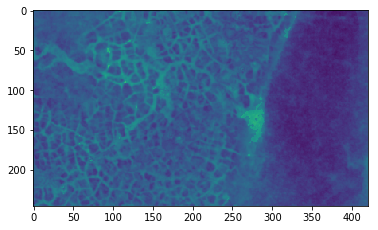

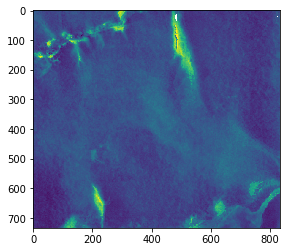

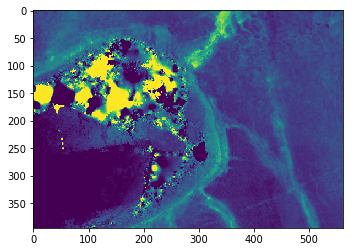

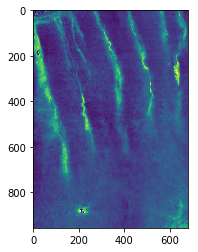

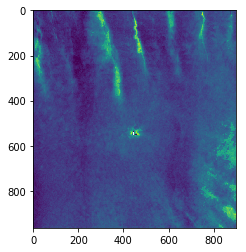

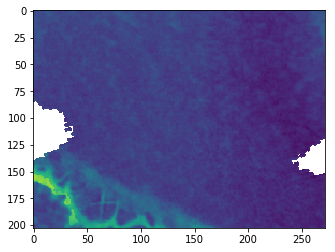

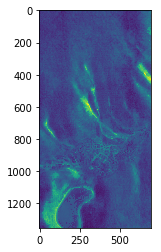

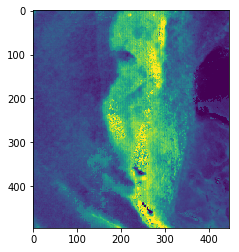

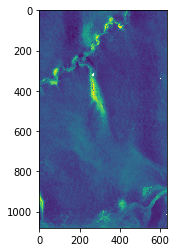

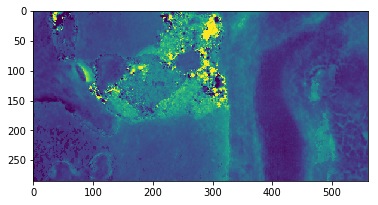

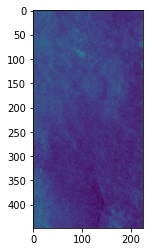

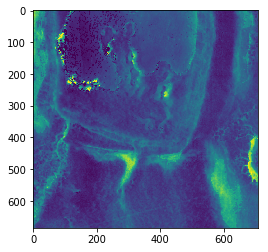

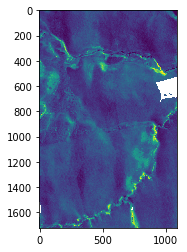

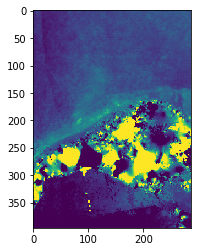

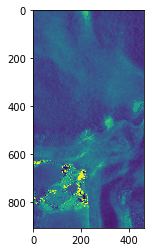

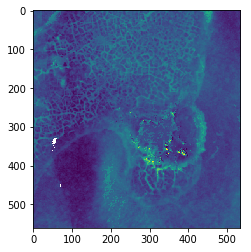

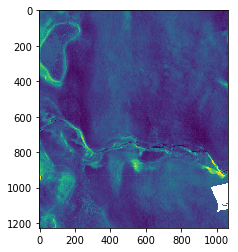

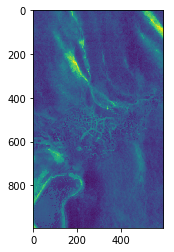

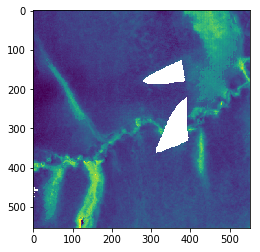

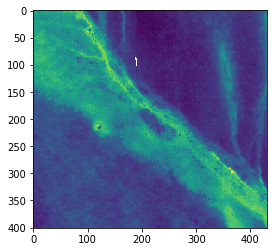

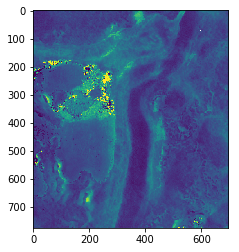

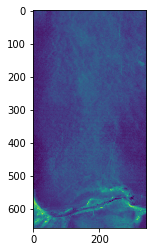

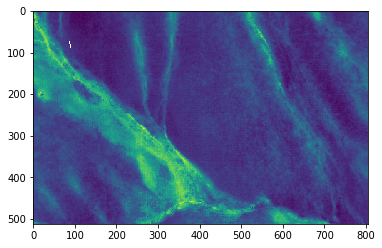

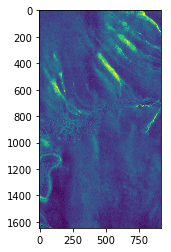

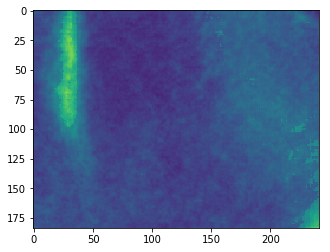

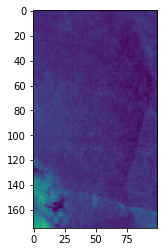

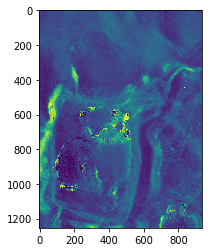

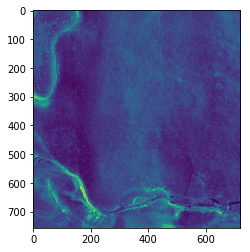

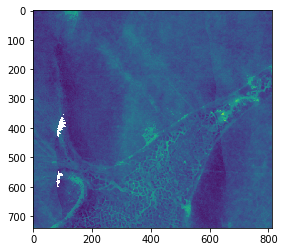

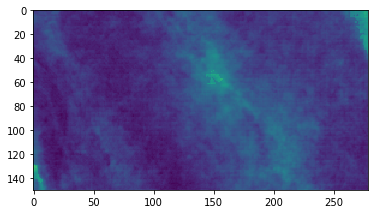

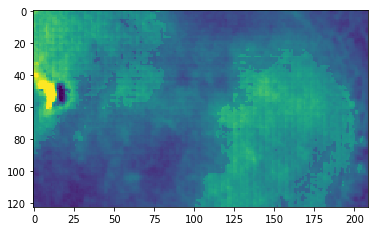

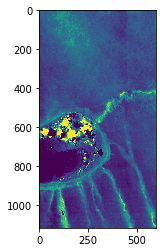

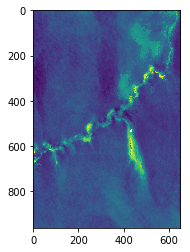

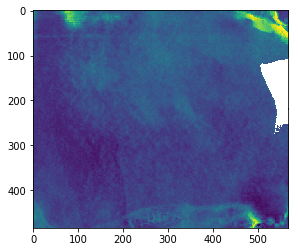

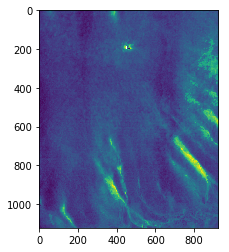

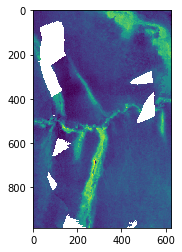

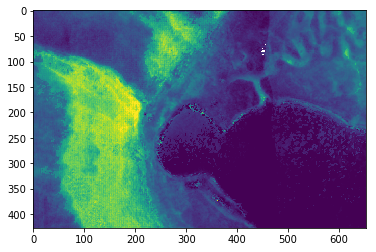

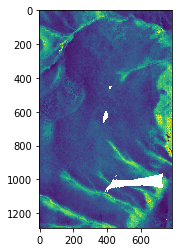

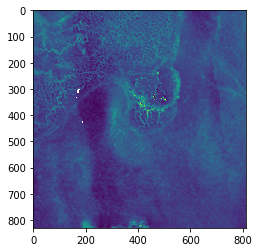

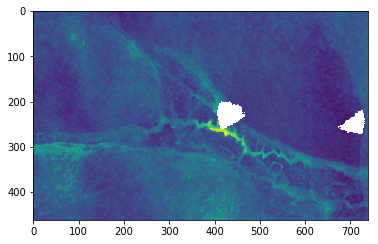

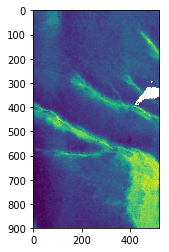

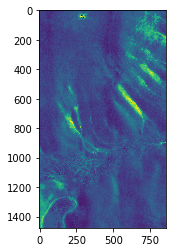

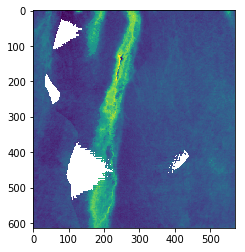

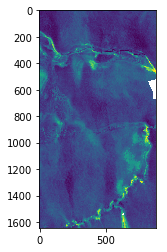

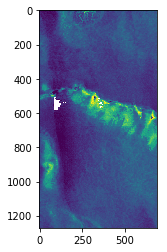

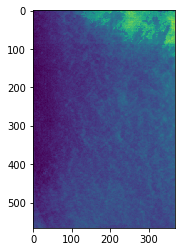

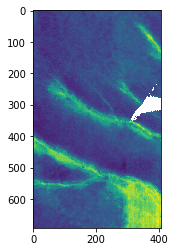

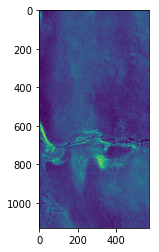

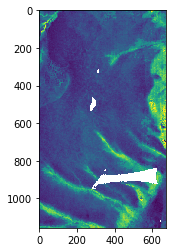

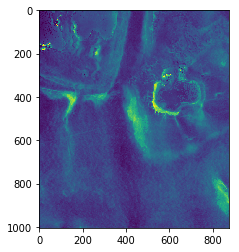

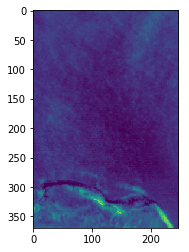

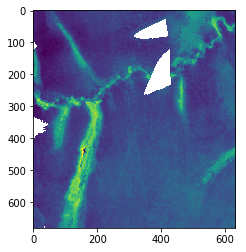

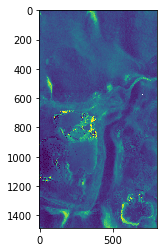

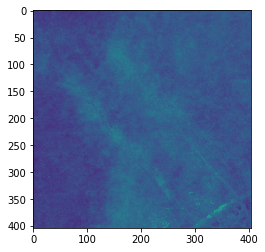

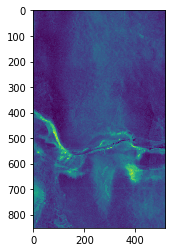

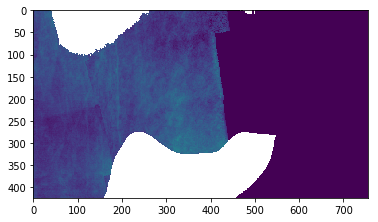

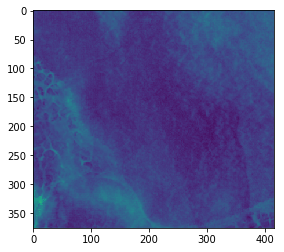

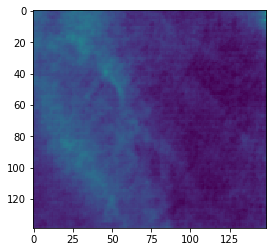

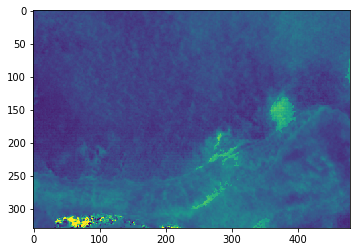

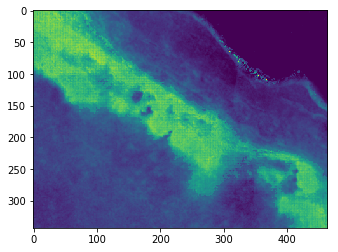

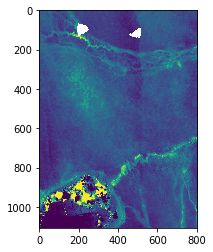

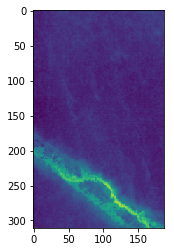

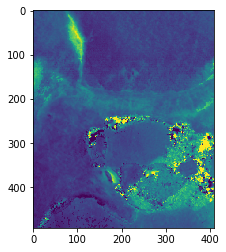

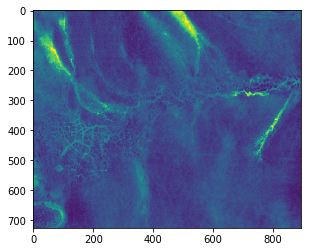

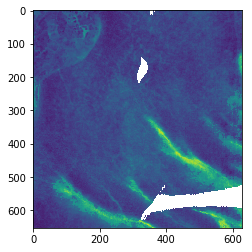

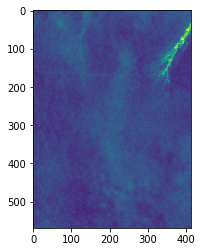

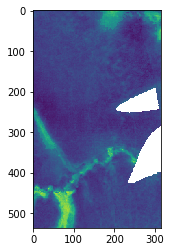

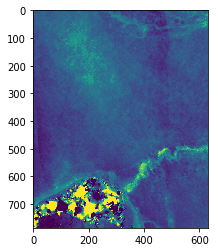

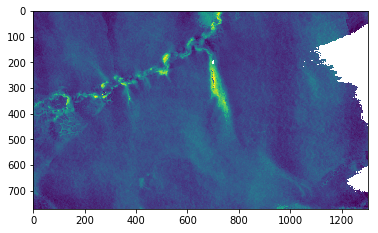

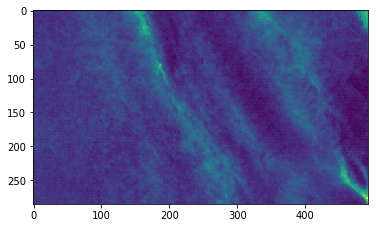

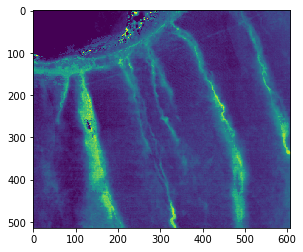

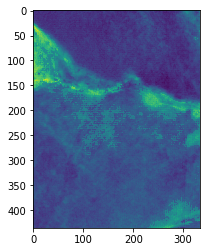

In [220]:
plt.clf()
for x in read_windows:
    a = src.read(1, window=x, masked=True)
    plt.figure()
    #plt.title(x)
    plt.imshow(a, vmin=0, vmax=2)


# a = src.read(1, window=read_windows[7])
# a
# plt.imshow(a, vmin=0, vmax=1)

In [202]:
read_windows[0]

((6811, 7321), (1491, 1936))

In [207]:
d_random = {}

p = 1

for k in read_windows:

    array_tag = 'random_array_' + str(p)
    d_random[array_tag] = {}

    d_random[array_tag]['bounds'] = k
    d_random[array_tag]['depth'] = src.read(1, window=k, masked=True)
    d_random[array_tag]['area'] = d_random[array_tag]['depth'].shape[0]*d_random[array_tag]['depth'].shape[1]/1000000
    p += 1

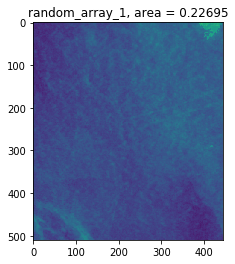

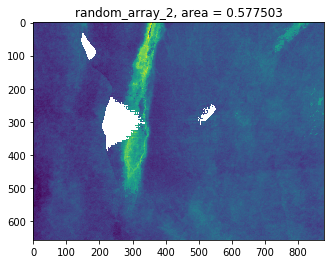

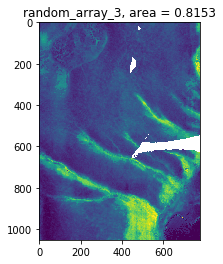

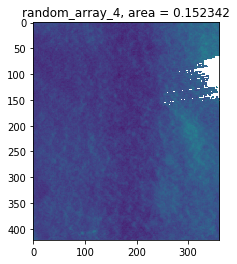

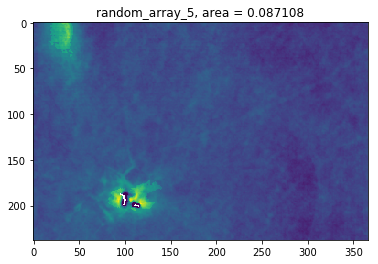

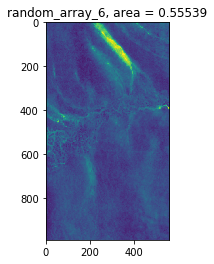

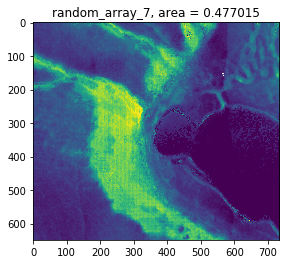

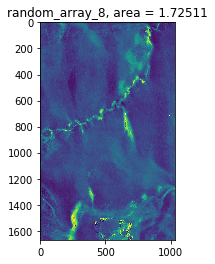

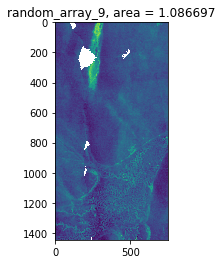

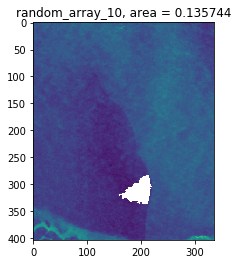

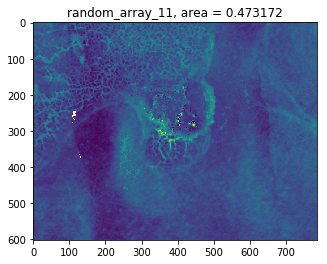

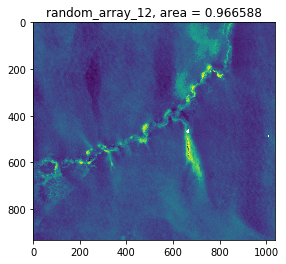

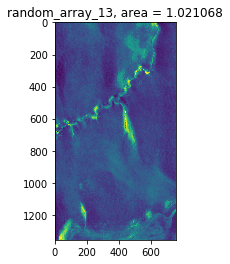

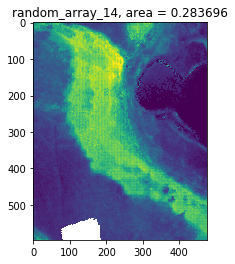

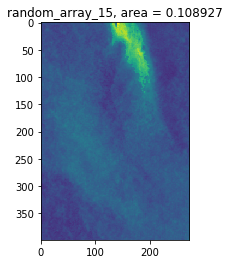

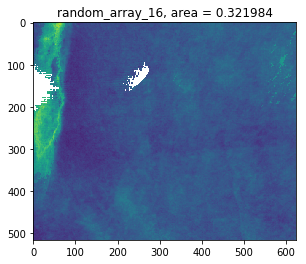

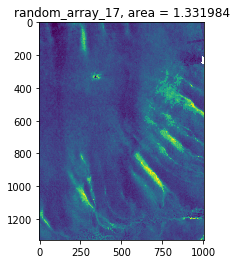

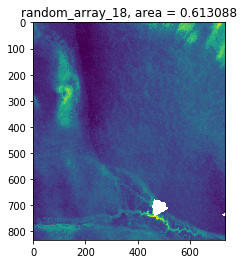

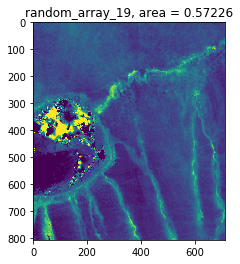

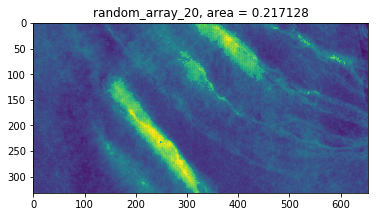

In [208]:
for x in d_random.keys():
    plt.figure()
    plt.title(x + ', area = ' + str(d_random[x]['area']))
    plt.imshow(d_random[x]['depth'], vmin=0, vmax=2)

In [3]:
# Get neat and tidy windows based on common scale factors

def factors(n):
    results = set()
    for i in range(1, int(math.sqrt(n)) + 1):
        if n % i == 0:
            results.add(i)
            results.add(int(n/i))
    return results

xfac = factors(width)
yfac = factors(height)
common_facs = xfac.intersection(yfac)
common_facs.discard(1)
common_facs.discard(2)
common_facs.discard(4)

xy_window_coord_increments = []
for i in list(common_facs):
    x, y = (width / i), (height / i)
    if x > 100 and y > 100 and x != width:    
        xy_window_coord_increments.append([x,y])


In [ ]:
d = dict()

for i in xy_window_coord_increments:
    area = str(round(i[0] * i[1] / 1000000, 2)) + ' sq. km'
    
    d[area] = {}
    
    d[area]['x step'] = int(i[0])
    d[area]['y step'] = int(i[1])
    d[area]['x starts'] = [int(a) for a in np.arange(0, width, i[0])]
    d[area]['y starts'] = [int(a) for a in np.arange(0, height, i[1])]
    #d[area]['offs'] = [a for a in zip(d[area]['x starts'], d[area]['y starts'])]
    
    d[area]['neat_windows'] = {}
    
    j = 0
    
    while j < len(d[area]['y starts']):
        array_tag = 'neat_array_' + str(j+1)
        d[area]['neat_windows'][array_tag] = {}
        d[area]['neat_windows'][array_tag]['bounds'] = Window(d[area]['x starts'][j-1],
                                                         d[area]['x starts'][j-1],
                                                         d[area]['x step'],
                                                         d[area]['y step'])
        d[area]['neat_windows'][array_tag]['depth'] = src.read(1, window=d[area]['neat_windows'][array_tag]['bounds'],
                                                         masked=True)

        j += 1
    
